# **Feature Correlation Analysis (Key Concept 1):**

Analyzes relationships between different city features
Creates a correlation matrix and heatmap visualization
Helps identify which features are most important

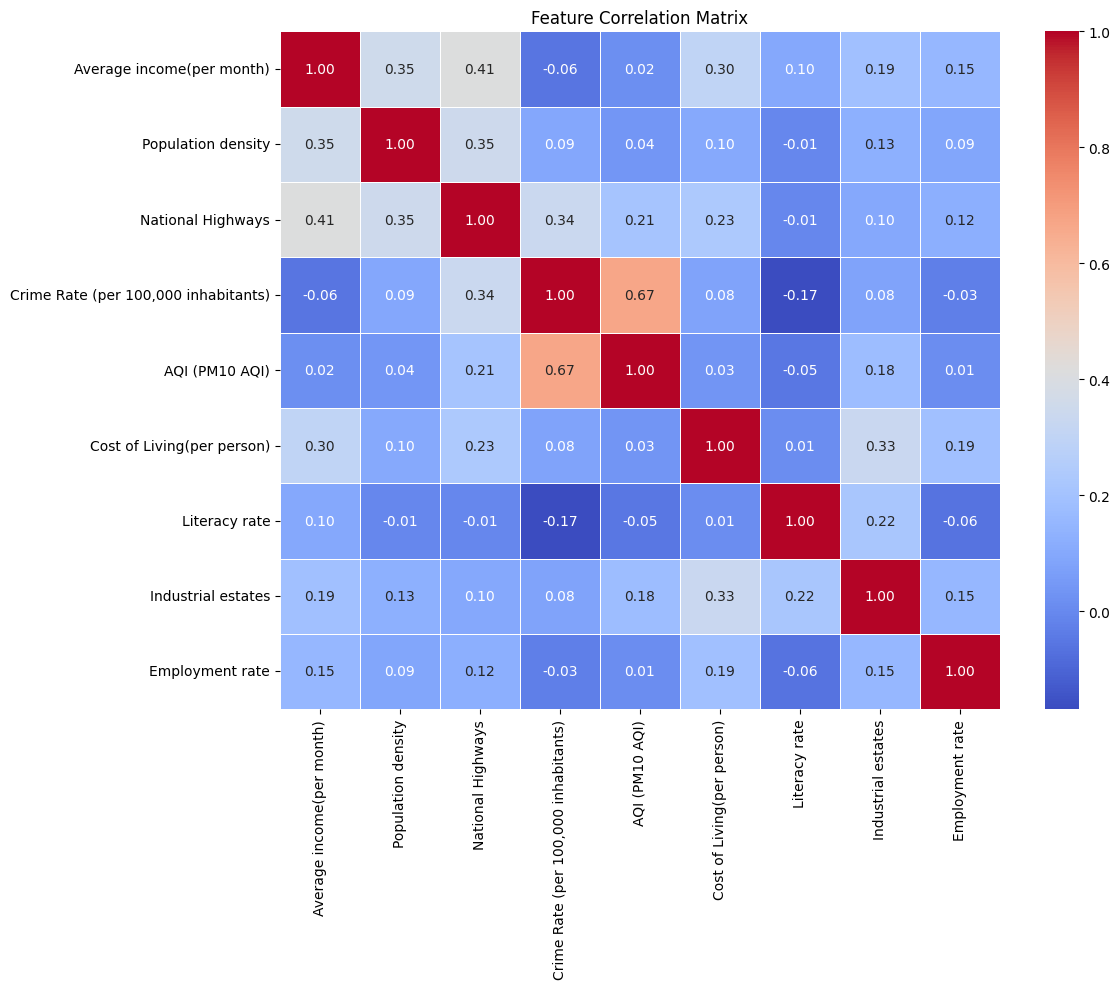

Feature importance based on correlation:
National Highways: 0.3066
Average income(per month): 0.2863
Crime Rate (per 100,000 inhabitants): 0.2792
Industrial estates: 0.2632
Cost of Living(per person): 0.2524
AQI (PM10 AQI): 0.2445
Population density: 0.2394
Employment rate: 0.2007
Literacy rate: 0.1802

Top 3 most important features:
National Highways                       0.306573
Average income(per month)               0.286327
Crime Rate (per 100,000 inhabitants)    0.279191
dtype: float64


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def load_and_preprocess_data(file_path):
    """Load and preprocess the city data."""
    df = pd.read_excel("/content/Smart cities.xlsx")
    # Clean column names
    df.columns = df.columns.str.strip()

    # Convert currency values to numeric
    for col in ['Average income(per month)', 'Cost of Living(per person)']:
        df[col] = df[col].astype(str).str.replace('₹', '').str.replace(',', '').astype(float)

    # Convert percentage to numeric
    df['Literacy rate'] = df['Literacy rate'].astype(str).str.replace('%', '').astype(float)

    # Convert target to binary
    if 'Target' in df.columns:
        df['Target'] = df['Target'].map({'Yes': 1, 'No': 0})

    return df

def analyze_feature_correlations(df):
    """
    Analyze and visualize correlations between features.

    Args:
        df: DataFrame with city data
    """
    # Select numerical columns for correlation analysis
    numerical_cols = [
        'Average income(per month)',
        'Population density',
        'National Highways',
        'Crime Rate (per 100,000 inhabitants)',
        'AQI (PM10 AQI)',
        'Cost of Living(per person)',
        'Literacy rate',
        'Industrial estates',
        'Employment rate'
    ]

    numerical_df = df[numerical_cols]

    # Calculate correlation matrix
    corr_matrix = numerical_df.corr()

    # Plot correlation heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title('Feature Correlation Matrix')
    plt.tight_layout()
    plt.savefig('feature_correlations.png')
    plt.show()

    # Find the most important features (those with highest correlation to other features)
    feature_importance = corr_matrix.abs().mean().sort_values(ascending=False)
    print("Feature importance based on correlation:")
    for feature, score in feature_importance.items():
        print(f"{feature}: {score:.4f}")

    return corr_matrix, feature_importance

if __name__ == "__main__":
    # Replace with your file path
    file_path = "smart_cities_data.csv"

    # Load and preprocess data
    df = load_and_preprocess_data(file_path)

    # Analyze correlations
    corr_matrix, feature_importance = analyze_feature_correlations(df)

    print("\nTop 3 most important features:")
    print(feature_importance.head(3))

# **Personalized Ranking System (Key Concept 2):**

Allows users to assign weights to different features
Standardizes the data for fair comparison
Ranks cities based on personalized preferences
Handles both positive and negative features (where higher values are worse)

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

def get_user_weights():
    """Get feature weights from user input."""
    print("Please rate the importance of each feature (0-10):")

    features = {
        'Infrastructure': ['National Highways', 'Population density'],
        'Economy': ['Average income(per month)', 'Industrial estates', 'Employment rate'],
        'Environment': ['AQI (PM10 AQI)'],
        'Safety': ['Crime Rate (per 100,000 inhabitants)'],
        'Education': ['Literacy rate'],
        'Cost': ['Cost of Living(per person)']
    }

    weights = {}

    for category, category_features in features.items():
        print(f"\n--- {category} ---")
        for feature in category_features:
            while True:
                try:
                    weight = int(input(f"Rate importance of {feature} (0-10): "))
                    if 0 <= weight <= 10:
                        weights[feature] = weight
                        break
                    else:
                        print("Please enter a number between 0 and 10.")
                except ValueError:
                    print("Please enter a valid number.")

    return weights

def create_personalized_ranking(df, user_weights):
    """
    Create a personalized ranking of cities based on user weights.

    Args:
        df: DataFrame with city data
        user_weights: Dictionary mapping features to importance weights (0-10)
    """
    # Features to consider
    features = list(user_weights.keys())

    # Create a copy of the dataframe for ranking
    ranking_df = df.copy()

    # Standardize features to make them comparable
    scaler = StandardScaler()
    features_array = ranking_df[features].values
    scaled_features = scaler.fit_transform(features_array)
    scaled_df = pd.DataFrame(scaled_features, columns=features)

    # Calculate weighted scores
    # Note: For some features, higher is worse (e.g., crime rate, AQI, cost of living)
    negative_features = [
        'Crime Rate (per 100,000 inhabitants)',
        'AQI (PM10 AQI)',
        'Cost of Living(per person)'
    ]

    weighted_scores = pd.DataFrame(index=df.index)

    for feature in features:
        weight = user_weights[feature]
        if feature in negative_features:
            # Invert the score for negative features (higher is worse)
            weighted_scores[feature] = -1 * scaled_df[feature] * weight
        else:
            weighted_scores[feature] = scaled_df[feature] * weight

    # Calculate total score
    ranking_df['Total Score'] = weighted_scores.sum(axis=1)

    # Rank cities (higher score is better)
    ranking_df['Rank'] = ranking_df['Total Score'].rank(ascending=False)

    # Sort by rank
    ranked_cities = ranking_df.sort_values('Rank')

    return ranked_cities[['City', 'Total Score', 'Rank'] + features]

def search_city(ranked_cities, city_name):
    """Search for a specific city in the ranked list."""
    # Handle NaN values by filling with an empty string before applying str.contains
    city_data = ranked_cities[ranked_cities['City'].fillna('').str.contains(city_name, case=False)]
    return city_data

if __name__ == "__main__":
    # Replace with your file path
    file_path = "smart_cities_data.csv"

    # Load and preprocess data
    df = load_and_preprocess_data("/content/Smart cities list (2) (1).xlsx")

    # Get user preferences
    print("Welcome to the City Ranking System!")
    use_default = input("Use default weights? (y/n): ").lower() == 'y'

    if use_default:
        # Default weights
        user_weights = {
            'National Highways': 9,
            'Population density': 3,
            'Average income(per month)': 8,
            'Industrial estates': 6,
            'Employment rate': 2,
            'AQI (PM10 AQI)': 4,
            'Crime Rate (per 100,000 inhabitants)': 7,
            'Literacy rate': 1,
            'Cost of Living(per person)': 5
        }
    else:
        # Get weights from user input
        user_weights = get_user_weights()

    # Create personalized ranking
    ranked_cities = create_personalized_ranking(df, user_weights)

    # Display top 10 cities
    print("\nTop 10 Cities based on your preferences:")
    print(ranked_cities[['City', 'Rank', 'Total Score']].head(10))

    # Allow user to search for specific cities
    while True:
        city_search = input("\nSearch for a specific city (or 'q' to quit): ")
        if city_search.lower() == 'q':
            break

        result = search_city(ranked_cities, city_search)
        if not result.empty:
            print(result[['City', 'Rank', 'Total Score']])
        else:
            print(f"No cities found matching '{city_search}'")

Welcome to the City Ranking System!
Use default weights? (y/n): y

Top 10 Cities based on your preferences:
         City  Rank  Total Score
15     Mumbai   1.0    83.899844
12  Bengaluru   2.0    37.202747
1     Chennai   3.0    35.590186
32        Leh   4.0    33.789637
35  Ahmedabad   5.0    33.741059
25   Dehradun   6.0    25.101465
34      Jammu   7.0    23.724594
0   Hyderabad   8.0    22.682960
48   Varanasi   9.0    19.325395
14     Bhopal  10.0    17.663415

Search for a specific city (or 'q' to quit): q


# **Predicting Missing Data (Key Concept 3):**
Uses Random Forest Regression to predict missing values
Works with any target column (Safety, Economy, etc.)
Reports feature importance for predictions

# **Key Concept 4: Finding Which Category Your City Falls In**

Implements K-Means clustering to group similar cities
Uses the Elbow Method to find the optimal number of clusters
Categorizes clusters as "Best Fit", "Moderate Fit", or "Poor Fit"
Visualizes city clusters in 2D using PCA
Implements KNN classification for categorizing new cities

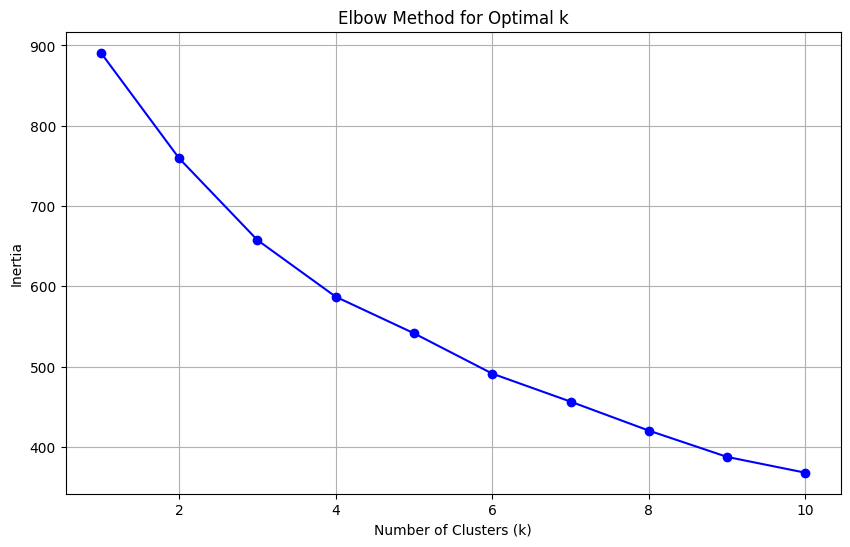


Cluster Centers:

Cluster 0 (Poor Fit):
  Average income(per month): 28000.00
  Population density: 4929.96
  National Highways: 1.96
  Crime Rate (per 100,000 inhabitants): 712.92
  AQI (PM10 AQI): 135.83
  Cost of Living(per person): 32541.67
  Literacy rate: 0.89
  Industrial estates: 13.17
  Employment rate: 0.89

Cluster 1 (Moderate Fit):
  Average income(per month): 28200.37
  Population density: 7551.01
  National Highways: 3.10
  Crime Rate (per 100,000 inhabitants): 1088.33
  AQI (PM10 AQI): 162.47
  Cost of Living(per person): 33094.15
  Literacy rate: 0.86
  Industrial estates: 11.74
  Employment rate: 0.91

Cluster 2 (Best Fit):
  Average income(per month): 32070.00
  Population density: 12848.00
  National Highways: 4.20
  Crime Rate (per 100,000 inhabitants): 1105.20
  AQI (PM10 AQI): 165.00
  Cost of Living(per person): 35600.00
  Literacy rate: 0.88
  Industrial estates: 19.20
  Employment rate: 0.91

Cities by Category:

Best Fit (10 cities):
Hyderabad, Chennai, Benga

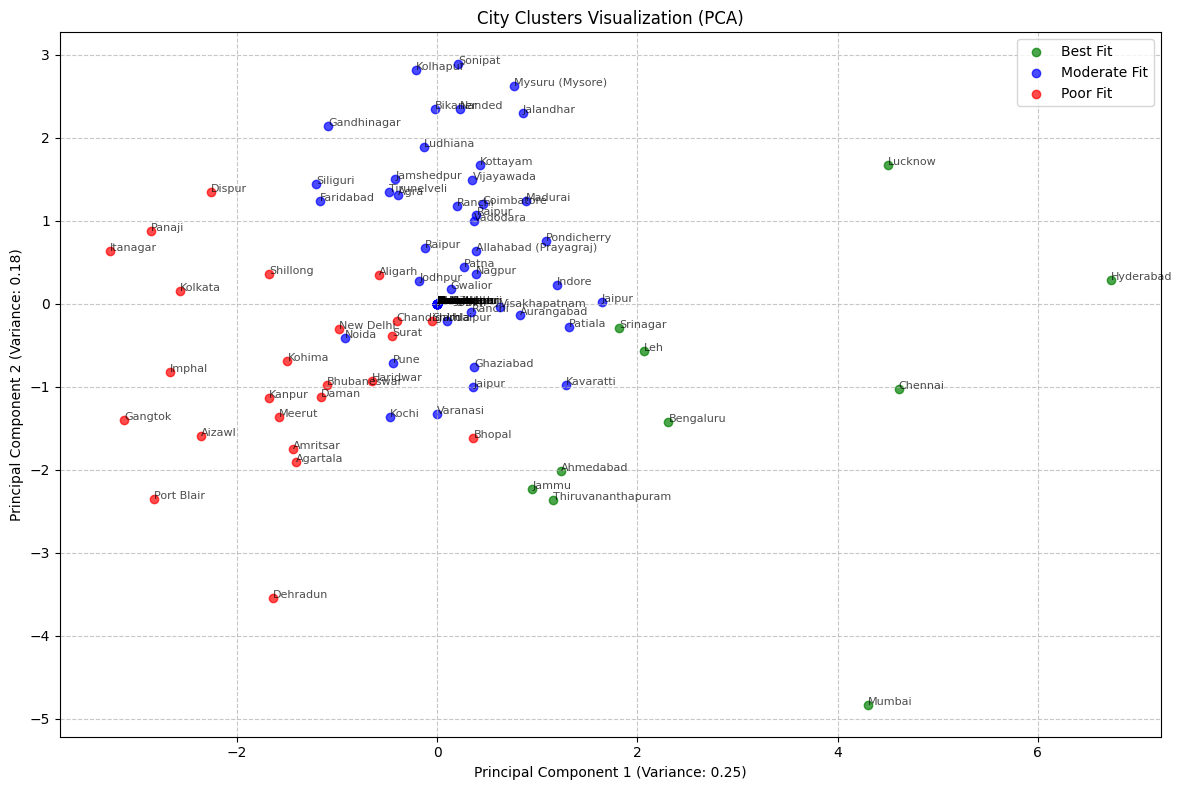

KNN Classifier Accuracy: 0.8667

Classification Report:
              precision    recall  f1-score   support

    Best Fit       1.00      1.00      1.00         4
Moderate Fit       0.81      1.00      0.89        17
    Poor Fit       1.00      0.56      0.71         9

    accuracy                           0.87        30
   macro avg       0.94      0.85      0.87        30
weighted avg       0.89      0.87      0.85        30


New city 'New City' is classified as: Moderate Fit
Probabilities:
  Best Fit: 0.2000
  Moderate Fit: 0.6000
  Poor Fit: 0.2000


In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer # Import SimpleImputer for handling NaNs

def find_optimal_clusters(df, features, max_k=10):
    """Find optimal number of clusters using the Elbow Method."""
    # Impute missing values using the mean strategy
    imputer = SimpleImputer(strategy='mean')
    X = imputer.fit_transform(df[features])

    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    inertia = []
    for k in range(1, max_k+1):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(X)
        inertia.append(kmeans.inertia_)

    # Plot Elbow Method
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, max_k+1), inertia, 'bo-')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia')
    plt.title('Elbow Method for Optimal k')
    plt.grid(True)
    plt.savefig('elbow_method.png')
    plt.show()

    return inertia

def cluster_cities(df, features, n_clusters=3):
    """
    Cluster cities into categories using K-Means.

    Args:
        df: DataFrame with city data
        features: Features to use for clustering
        n_clusters: Number of clusters to create

    Returns:
        DataFrame with cluster assignments
    """
    # Impute missing values before scaling and clustering
    imputer = SimpleImputer(strategy='mean')  # or other strategy like 'median'
    df[features] = imputer.fit_transform(df[features])

    # Standardize features
    scaler = StandardScaler()
    X = scaler.fit_transform(df[features])

    # Apply K-Means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(X)

    # Add cluster assignment to dataframe
    df_clustered = df.copy()
    df_clustered['Cluster'] = clusters

    # Calculate cluster centers
    centers = scaler.inverse_transform(kmeans.cluster_centers_)
    cluster_centers = pd.DataFrame(centers, columns=features)

    # Determine cluster categories (Best Fit, Moderate Fit, Poor Fit)
    # For demonstration, we'll use a simple approach based on average feature values
    # In practice, you might want a more sophisticated approach depending on your domain knowledge

    # Create a score for each cluster (higher is better)
    scores = {}

    for i in range(n_clusters):
        # Calculate average score across features
        # Note: For negative features, higher values are worse
        negative_features = ['Crime Rate (per 100,000 inhabitants)', 'AQI (PM10 AQI)', 'Cost of Living(per person)']

        score = 0
        for feature in features:
            feature_value = cluster_centers.loc[i, feature]
            if feature in negative_features:
                # Invert the score for negative features
                score -= feature_value
            else:
                score += feature_value

        scores[i] = score

    # Rank clusters by score
    ranked_clusters = pd.Series(scores).rank(ascending=False)

    # Map rank to category
    category_map = {}
    for cluster, rank in ranked_clusters.items():
        if rank == 1:
            category_map[cluster] = "Best Fit"
        elif rank == 2:
            category_map[cluster] = "Moderate Fit"
        else:
            category_map[cluster] = "Poor Fit"

    # Assign categories to cities
    df_clustered['Category'] = df_clustered['Cluster'].map(category_map)

    return df_clustered, cluster_centers, category_map

def visualize_clusters(df, features, category_map):
    """Visualize clusters using PCA for dimensionality reduction."""
    from sklearn.decomposition import PCA

    # Standardize features
    scaler = StandardScaler()
    X = scaler.fit_transform(df[features])

    # Apply PCA to reduce to 2 dimensions for visualization
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    # Create a dataframe for plotting
    plot_df = pd.DataFrame({
        'PCA1': X_pca[:, 0],
        'PCA2': X_pca[:, 1],
        'Cluster': df['Cluster'],
        'Category': df['Category'],
        'City': df['City']
    })

    # Plot clusters
    plt.figure(figsize=(12, 8))

    # Create a color map
    categories = ["Best Fit", "Moderate Fit", "Poor Fit"]
    colors = ["green", "blue", "red"]
    category_colors = {cat: col for cat, col in zip(categories, colors)}

    # Plot each category
    for category in categories:
        subset = plot_df[plot_df['Category'] == category]
        plt.scatter(subset['PCA1'], subset['PCA2'],
                   label=category,
                   alpha=0.7,
                   color=category_colors[category])

    # Add city labels
    for idx, row in plot_df.iterrows():
        plt.annotate(row['City'], (row['PCA1'], row['PCA2']),
                    fontsize=8, alpha=0.7)

    plt.title('City Clusters Visualization (PCA)')
    plt.xlabel(f'Principal Component 1 (Variance: {pca.explained_variance_ratio_[0]:.2f})')
    plt.ylabel(f'Principal Component 2 (Variance: {pca.explained_variance_ratio_[1]:.2f})')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig('city_clusters.png')
    plt.show()

def train_knn_classifier(df, features, n_neighbors=5):
    """
    Train a KNN classifier to categorize new cities.

    Args:
        df: DataFrame with city data including 'Category' column
        features: Features to use for classification
        n_neighbors: Number of neighbors for KNN

    Returns:
        Trained classifier
    """
    # Prepare data
    X = df[features]
    y = df['Category']

    # Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train KNN classifier
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(X_train_scaled, y_train)

    # Make predictions
    y_pred = knn.predict(X_test_scaled)

    # Evaluate classifier
    accuracy = accuracy_score(y_test, y_pred)
    print(f"KNN Classifier Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Return classifier and scaler (for future predictions)
    return knn, scaler

def classify_new_city(clf, scaler, features, new_city_data):
    """
    Classify a new city using the trained KNN classifier.

    Args:
        clf: Trained KNN classifier
        scaler: Fitted StandardScaler
        features: Features used for classification
        new_city_data: Dictionary with feature values for the new city

    Returns:
        Predicted category
    """
    # Create a dataframe with the new city data
    new_city_df = pd.DataFrame([new_city_data])

    # Ensure all features are present
    for feature in features:
        if feature not in new_city_df.columns:
            raise ValueError(f"Missing feature: {feature}")

    # Scale the features
    X = scaler.transform(new_city_df[features])

    # Make prediction
    category = clf.predict(X)[0]

    # Get prediction probabilities
    probabilities = clf.predict_proba(X)[0]
    prob_dict = {clf.classes_[i]: prob for i, prob in enumerate(probabilities)}

    return category, prob_dict

if __name__ == "__main__":
    # Replace with your file path
    file_path = "smart_cities_data.csv"

    # Load and preprocess data
    df = load_and_preprocess_data("/content/Smart cities list (2).xlsx")

    # Features to use for clustering
    features = [
        'Average income(per month)',
        'Population density',
        'National Highways',
        'Crime Rate (per 100,000 inhabitants)',
        'AQI (PM10 AQI)',
        'Cost of Living(per person)',
        'Literacy rate',
        'Industrial estates',
        'Employment rate'
    ]

    # Find optimal number of clusters
    inertia = find_optimal_clusters(df, features)

    # Choose number of clusters (typically from elbow method)
    n_clusters = 3  # Can be adjusted based on the elbow plot

    # Cluster cities
    df_clustered, cluster_centers, category_map = cluster_cities(df, features, n_clusters)

    # Display cluster centers
    print("\nCluster Centers:")
    for cluster, category in category_map.items():
        print(f"\nCluster {cluster} ({category}):")
        for feature in features:
            print(f"  {feature}: {cluster_centers.loc[cluster, feature]:.2f}")

    # Display cities in each category
    print("\nCities by Category:")
    for category in df_clustered['Category'].unique():
        cities = df_clustered[df_clustered['Category'] == category]['City'].tolist()
        print(f"\n{category} ({len(cities)} cities):")
        print(", ".join(cities[:10]) + ("..." if len(cities) > 10 else ""))

    # Visualize clusters
    visualize_clusters(df_clustered, features, category_map)

    # Train KNN classifier for new cities
    knn_clf, knn_scaler = train_knn_classifier(df_clustered, features)

    # Example: Classify a new city
    new_city = {
        'City': 'New City',
        'Average income(per month)': 30000,
        'Population density': 15000,
        'National Highways': 4,
        'Crime Rate (per 100,000 inhabitants)': 1100,
        'AQI (PM10 AQI)': 150,
        'Cost of Living(per person)': 34000,
        'Literacy rate': 88.5,
        'Industrial estates': 12,
        'Employment rate': 91.0
    }

    category, probabilities = classify_new_city(knn_clf, knn_scaler, features, new_city)

    print(f"\nNew city '{new_city['City']}' is classified as: {category}")
    print("Probabilities:")
    for cat, prob in probabilities.items():
        print(f"  {cat}: {prob:.4f}")

# **Cities similar to your city**

Available features for comparison: ['Average income(per month)', 'Population density', 'National Highways', 'Crime Rate (per 100,000 inhabitants)', 'AQI (PM10 AQI)', 'Cost of Living(per person)', 'Literacy rate', 'Industrial estates', 'Employment rate']
Enter your reference city name (e.g., Hyderabad): Chennai
Found data for Chennai in the dataset.

City Categories Based on Similarity to Your Reference City:

Best Fit (37 cities):
  Chennai - Similarity Score: 100.0
  Hyderabad - Similarity Score: 54.0
  Ghaziabad - Similarity Score: 44.6
  Bhopal - Similarity Score: 42.5
  Lucknow - Similarity Score: 41.7

Moderate Fit (29 cities):
  Allahabad (Prayagraj) - Similarity Score: 36.6
  Kavaratti - Similarity Score: 36.2
  Madurai - Similarity Score: 36.2
  Surat - Similarity Score: 34.7
  Chandigarh - Similarity Score: 34.0

Poor Fit (33 cities):
  Pondicherry - Similarity Score: 25.3
  Kanpur - Similarity Score: 24.1
  Raipur - Similarity Score: 23.7
  Faridabad - Similarity Score: 23.7


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


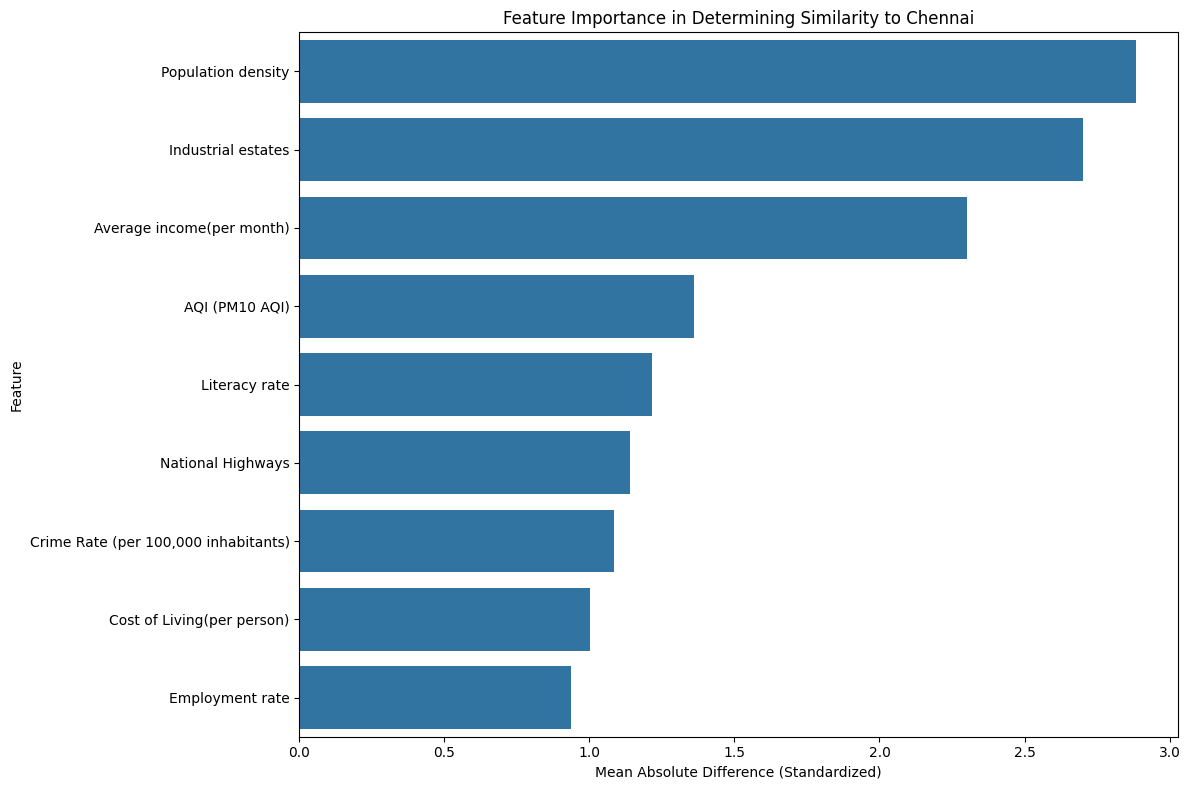

Most influential features for determining similarity:
  Population density: 26000.00 in Chennai
  Industrial estates: 32.00 in Chennai
  Average income(per month): 32000.00 in Chennai


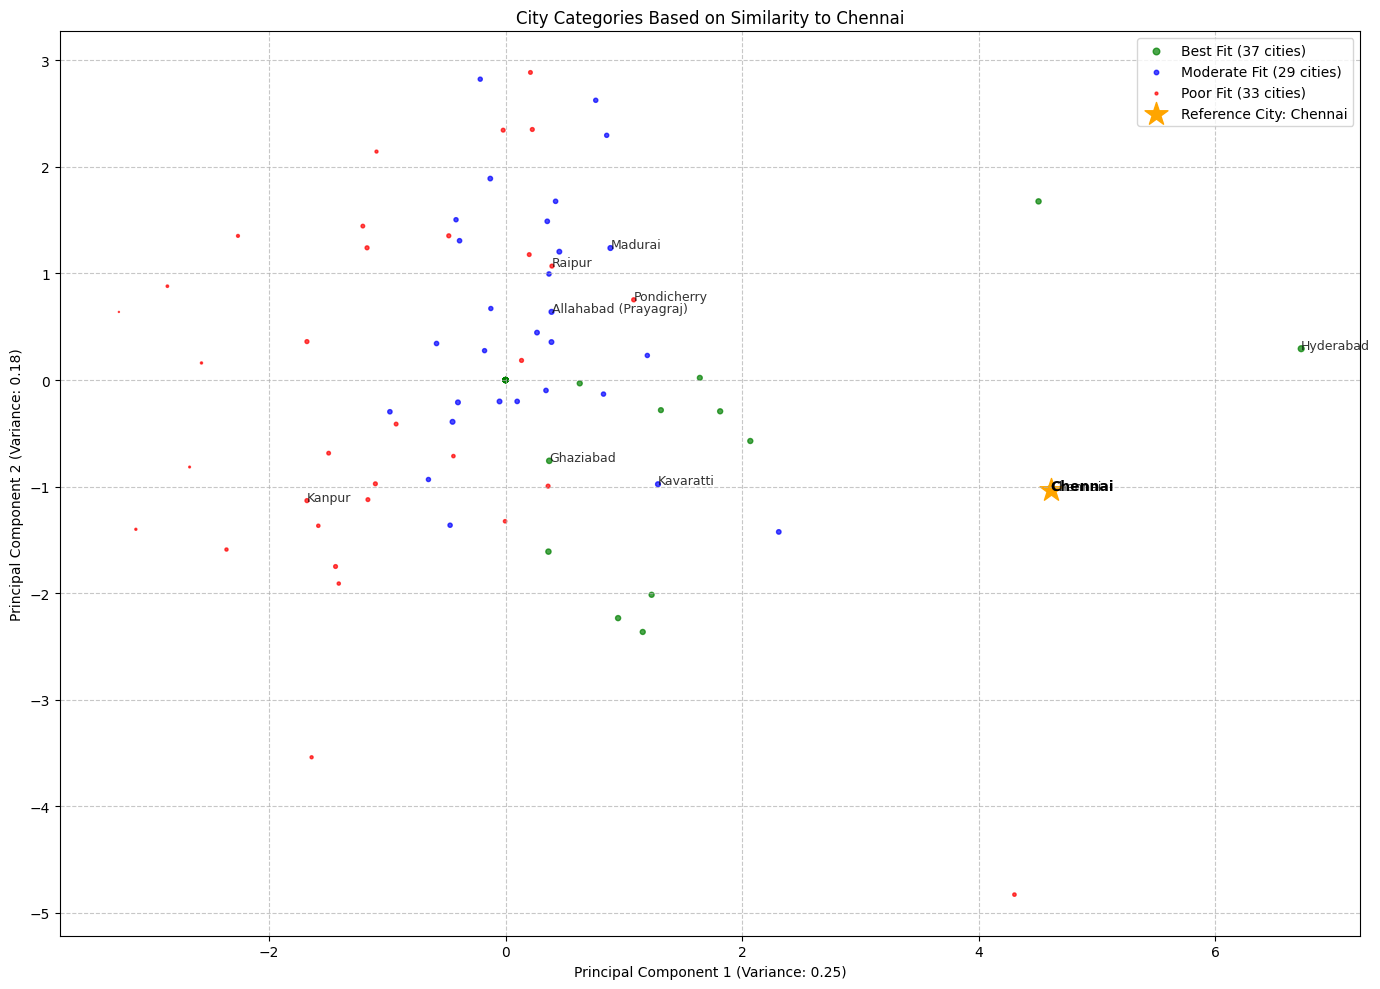

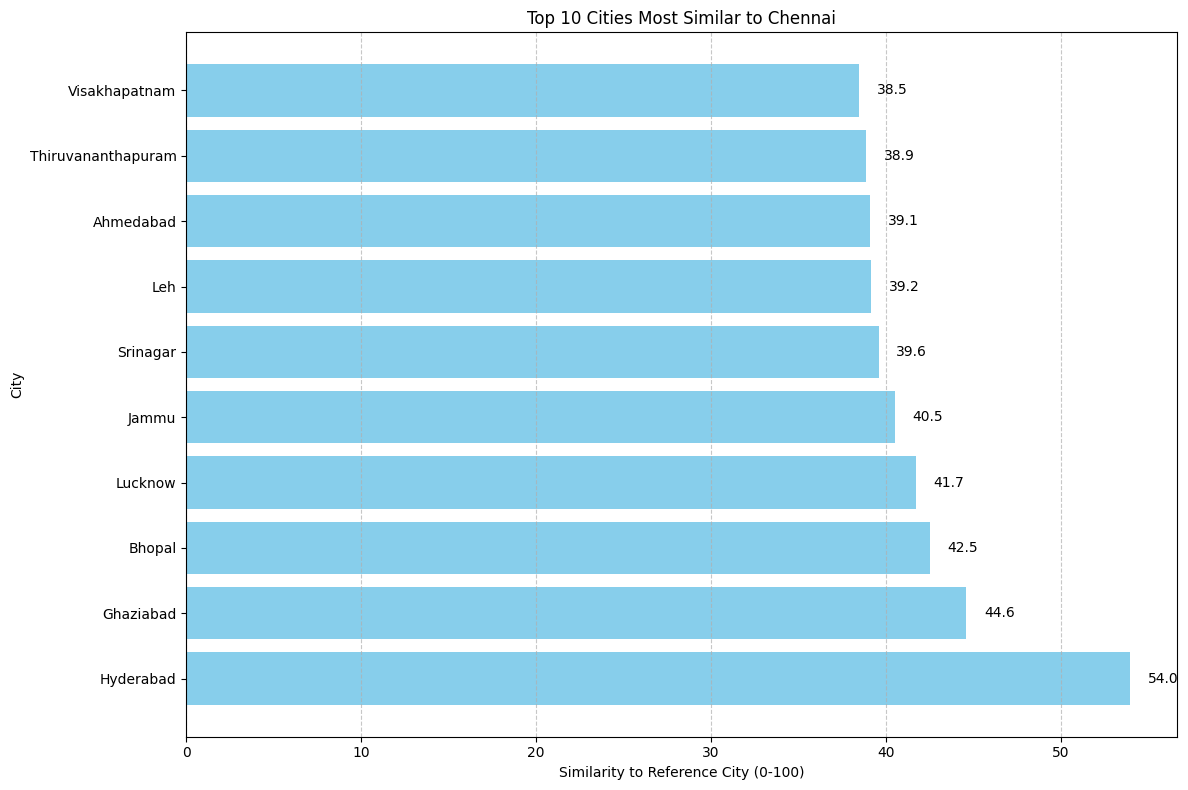


Analysis complete! Check the generated visualization files.


In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.impute import SimpleImputer

def load_and_preprocess_data():
    """Load and preprocess the smart cities data."""
    try:
        # Direct read_excel with no file path handling
        df = pd.read_excel("Smart cities.xlsx",  dtype={'City': str})

        # Clean column names
        df.columns = df.columns.str.strip()

        # Convert currency values to numeric
        for col in ['Average income(per month)', 'Cost of Living(per person)']:
            if col in df.columns:
                df[col] = df[col].astype(str).str.replace('₹', '').str.replace(',', '').astype(float)

        # Convert percentage to numeric
        if 'Literacy rate' in df.columns:
            df['Literacy rate'] = df['Literacy rate'].astype(str).str.replace('%', '').astype(float)

        return df
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

def get_reference_city_data(df, reference_city_name):
    """
    Get data for the reference city.
    If city is not in the dataset, allow manual input.
    """
    while reference_city_name not in df['City'].values:  # Keep asking until valid city is entered
        print(f"City '{reference_city_name}' not found in the dataset.")
        print("Please select a city that exists in the dataset.")
        reference_city_name = input("Enter your reference city name (e.g., Hyderabad): ")  # Get new input

    reference_city = df[df['City'] == reference_city_name].iloc[0].to_dict()
    print(f"Found data for {reference_city_name} in the dataset.")
    return reference_city



def categorize_cities_by_similarity(df, features, reference_city):
    """
    Categorize cities based on their similarity to the reference city.
    """
    # Impute missing values using SimpleImputer (before scaling)
    imputer = SimpleImputer(strategy='mean')  # You can change the strategy if needed
    df_imputed = pd.DataFrame(imputer.fit_transform(df[features]), columns=features, index=df.index)

    # Standardize features
    scaler = StandardScaler()
    X = scaler.fit_transform(df_imputed)

    # Create reference city vector for comparison
    reference_city_values = np.array([[reference_city[feature] for feature in features]])
    # Impute missing values in reference_city_values
    reference_city_values = imputer.transform(reference_city_values)
    reference_city_scaled = scaler.transform(reference_city_values)

    # Calculate Euclidean distances to reference city
    distances = euclidean_distances(X, reference_city_scaled)

    # Add distance and similarity scores to dataframe
    df_categorized = df.copy()
    df_categorized['Distance'] = distances.flatten()

    # Convert distance to similarity score (0-100)
    max_dist = df_categorized['Distance'].max()
    df_categorized['SimilarityScore'] = 100 * (1 - df_categorized['Distance'] / max_dist)

    # Categorize cities based on similarity score percentiles
    # Top 1/3 = Best Fit, Middle 1/3 = Moderate Fit, Bottom 1/3 = Poor Fit
    thresholds = np.percentile(df_categorized['SimilarityScore'], [33.33, 66.67])

    def assign_category(score):
        if score >= thresholds[1]:
            return "Best Fit"
        elif score >= thresholds[0]:
            return "Moderate Fit"
        else:
            return "Poor Fit"

    df_categorized['Category'] = df_categorized['SimilarityScore'].apply(assign_category)

    # Sort by similarity score (most similar first)
    df_categorized = df_categorized.sort_values('SimilarityScore', ascending=False)

    return df_categorized

def identify_key_similarities_differences(df_categorized, features, reference_city, top_n=5):
    """
    Identify key similarities and differences between top cities and the reference city.
    """
    # Get top similar cities
    top_cities = df_categorized[df_categorized['City'] != reference_city['City']].head(top_n)
    top_cities['City'] = top_cities['City'].astype(str)

    print(f"\n=== SIMILARITIES AND DIFFERENCES WITH TOP {top_n} CITIES ===")

    for idx, row in top_cities.iterrows():
        city_name = row['City']
        city_data = df_categorized[df_categorized['City'] == city_name].iloc[0]

        print(f"\n{city_name} (Similarity Score: {row['SimilarityScore']:.1f}, Category: {row['Category']})")

        # Calculate feature-wise differences
        differences = []
        for feature in features:
            reference_value = reference_city[feature]
            city_value = city_data[feature]

            # Calculate percentage difference
            if reference_value != 0:
                pct_diff = ((city_value - reference_value) / reference_value) * 100
            else:
                pct_diff = float('inf') if city_value != 0 else 0

            differences.append({
                'feature': feature,
                'reference_value': reference_value,
                'city_value': city_value,
                'abs_pct_diff': abs(pct_diff),
                'pct_diff': pct_diff
            })

        # Sort to find most similar and most different features
        differences.sort(key=lambda x: x['abs_pct_diff'])

        # Print most similar features
        print("  Most Similar Features:")
        for diff in differences[:3]:
            feature = diff['feature']
            ref_val = diff['reference_value']
            city_val = diff['city_value']
            pct_diff = diff['pct_diff']
            print(f"    {feature}: {city_val:.2f} ({'+' if pct_diff >= 0 else ''}{pct_diff:.1f}% compared to {ref_val:.2f})")

        # Print most different features
        print("  Most Different Features:")
        for diff in differences[-3:]:
            feature = diff['feature']
            ref_val = diff['reference_value']
            city_val = diff['city_value']
            pct_diff = diff['pct_diff']
            print(f"    {feature}: {city_val:.2f} ({'+' if pct_diff >= 0 else ''}{pct_diff:.1f}% compared to {ref_val:.2f})")

def visualize_categories(df_categorized, features, reference_city):
    """
    Visualize cities with their categories and highlight the reference city.
    """
    # Apply PCA for 2D visualization
    # Apply PCA for 2D visualization
    scaler = StandardScaler()
    # Impute missing values using SimpleImputer (before scaling)
    imputer = SimpleImputer(strategy='mean')  # You can change the strategy if needed
    X_imputed = imputer.fit_transform(df_categorized[features])
    X = scaler.fit_transform(X_imputed)

    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    # Create a dataframe for plotting
    plot_df = pd.DataFrame({
        'PCA1': X_pca[:, 0],
        'PCA2': X_pca[:, 1],
        'City': df_categorized['City'],
        'Category': df_categorized['Category'],
        'SimilarityScore': df_categorized['SimilarityScore']
    })

    # Project reference city onto PCA space if not already in dataframe
    if reference_city['City'] not in df_categorized['City'].values:
        reference_city_values = np.array([[reference_city[feature] for feature in features]])
        reference_city_scaled = scaler.transform(reference_city_values)
        reference_city_pca = pca.transform(reference_city_scaled)
    else:
        user_row = plot_df[plot_df['City'] == reference_city['City']].iloc[0]
        reference_city_pca = np.array([[user_row['PCA1'], user_row['PCA2']]])

    # Plot cities with categories
    plt.figure(figsize=(14, 10))

    # Create a color map
    categories = ["Best Fit", "Moderate Fit", "Poor Fit"]
    colors = ["green", "blue", "red"]
    category_colors = {cat: col for cat, col in zip(categories, colors)}

    # Plot each category
    for category in categories:
        subset = plot_df[plot_df['Category'] == category]
        plt.scatter(subset['PCA1'], subset['PCA2'],
                   label=f"{category} ({len(subset)} cities)",
                   alpha=0.7,
                   color=category_colors[category],
                   s=subset['SimilarityScore']/3)  # Size based on similarity score

    # Highlight reference city
    plt.scatter(reference_city_pca[0, 0], reference_city_pca[0, 1],
               marker='*', color='orange', s=300,
               label=f"Reference City: {reference_city['City']}")

    # Add city labels for top cities in each category
    for category in categories:
        subset = plot_df[plot_df['Category'] == category].nlargest(3, 'SimilarityScore')
        for idx, row in subset.iterrows():
            plt.annotate(row['City'], (row['PCA1'], row['PCA2']),
                        fontsize=9, alpha=0.8)

    # Always label reference city
    plt.annotate(reference_city['City'],
                (reference_city_pca[0, 0], reference_city_pca[0, 1]),
                fontsize=10, fontweight='bold')

    plt.title(f'City Categories Based on Similarity to {reference_city["City"]}')
    plt.xlabel(f'Principal Component 1 (Variance: {pca.explained_variance_ratio_[0]:.2f})')
    plt.ylabel(f'Principal Component 2 (Variance: {pca.explained_variance_ratio_[1]:.2f})')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig('city_categories.png')
    plt.show()

    # Create a bar chart of top cities by similarity
    top_cities = df_categorized[df_categorized['City'] != reference_city['City']].head(10)

    # Convert 'City' column to string before plotting
    top_cities['City'] = top_cities['City'].astype(str)  # Convert to string

    plt.figure(figsize=(12, 8))
    bars = plt.barh(top_cities['City'], top_cities['SimilarityScore'], color='skyblue')


    plt.xlabel('Similarity to Reference City (0-100)')
    plt.ylabel('City')
    plt.title(f'Top 10 Cities Most Similar to {reference_city["City"]}')
    plt.grid(True, axis='x', linestyle='--', alpha=0.7)

    # Add city scores as text
    for i, bar in enumerate(bars):
        plt.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2,
                f"{top_cities['SimilarityScore'].iloc[i]:.1f}",
                va='center')

    plt.tight_layout()
    plt.savefig('top_similar_cities.png')
    plt.show()

def analyze_feature_importance(df, features, reference_city_name):
    """
    Analyze which features are most important for determining similarity.
    """
    print("\n=== FEATURE IMPORTANCE ANALYSIS ===")

    # For each feature, calculate how much it contributes to similarity scores
    feature_importance = {}

    # Reference city
    reference_city_data = df[df['City'] == reference_city_name]

    if len(reference_city_data) == 0:
        print(f"Reference city {reference_city_name} not found in dataset. Skipping feature importance analysis.")
        return

    reference_values = reference_city_data[features].iloc[0].to_dict()

    # Standardize data
    scaler = StandardScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df[features]), columns=features)

    # Reference values standardized
    reference_scaled = pd.DataFrame(scaler.transform(reference_city_data[features]), columns=features).iloc[0].to_dict()

    # Calculate absolute differences for each feature
    for feature in features:
        # Calculate absolute differences
        df_scaled[f'diff_{feature}'] = (df_scaled[feature] - reference_scaled[feature]).abs()

    # Calculate mean difference for each feature
    for feature in features:
        mean_diff = df_scaled[f'diff_{feature}'].mean()
        feature_importance[feature] = mean_diff

    # Convert to DataFrame for easier manipulation
    importance_df = pd.DataFrame({
        'Feature': list(feature_importance.keys()),
        'Importance': list(feature_importance.values())
    })

    # Higher difference means more influential in determining similarity/dissimilarity
    importance_df = importance_df.sort_values('Importance', ascending=False)

    # Plot feature importance
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=importance_df)
    plt.title(f'Feature Importance in Determining Similarity to {reference_city_name}')
    plt.xlabel('Mean Absolute Difference (Standardized)')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.savefig('feature_importance.png')
    plt.show()

    # Print top 3 most important features
    print("Most influential features for determining similarity:")
    for idx, row in importance_df.head(3).iterrows():
        feature = row['Feature']
        value = reference_values[feature]
        print(f"  {feature}: {value:.2f} in {reference_city_name}")

def display_category_statistics(df_categorized, features, reference_city):
    """
    Display statistics for each category compared to the reference city.
    """
    print("\n=== CATEGORY STATISTICS ===")

    # Create a dataframe with reference city metrics
    reference_values = {feature: reference_city[feature] for feature in features}

    # For each category, calculate average values and compare to reference city
    for category in ["Best Fit", "Moderate Fit", "Poor Fit"]:
        category_df = df_categorized[df_categorized['Category'] == category]

        print(f"\n{category} ({len(category_df)} cities):")

        if len(category_df) == 0:
            continue

        # Calculate mean values for each feature in this category
        category_means = category_df[features].mean()

        # Calculate percentage difference from reference city
        for feature in features:
            ref_value = reference_values[feature]
            cat_value = category_means[feature]

            # Calculate percent difference
            if ref_value != 0:
                pct_diff = ((cat_value - ref_value) / ref_value) * 100
                direction = "higher" if pct_diff > 0 else "lower"
                print(f"  {feature}: {cat_value:.2f} ({abs(pct_diff):.1f}% {direction} than {reference_city['City']})")
            else:
                print(f"  {feature}: {cat_value:.2f} (N/A - reference value is 0)")

def main():
    # Load and preprocess data with direct read_excel
    df = load_and_preprocess_data()

    if df is None:
        print("Failed to load data. Please check that 'Smart cities.xlsx' is in the current directory.")
        return

    # Features to use for comparison
    features = [
        'Average income(per month)',
        'Population density',
        'National Highways',
        'Crime Rate (per 100,000 inhabitants)',
        'AQI (PM10 AQI)',
        'Cost of Living(per person)',
        'Literacy rate',
        'Industrial estates',
        'Employment rate'
    ]

    # Ensure all features exist in the dataset
    features = [f for f in features if f in df.columns]

    print("Available features for comparison:", features)

    # Get reference city name
    reference_city_name = input("Enter your reference city name (e.g., Hyderabad): ")
    reference_city = get_reference_city_data(df, reference_city_name)

    # Categorize cities based on similarity to reference city
    df_categorized = categorize_cities_by_similarity(df, features, reference_city)

    # Display categories
    print("\nCity Categories Based on Similarity to Your Reference City:")
    for category in ["Best Fit", "Moderate Fit", "Poor Fit"]:
        category_cities = df_categorized[df_categorized['Category'] == category]
        print(f"\n{category} ({len(category_cities)} cities):")
        top_5 = category_cities.head(5)  # Top 5 cities in each category
        for idx, row in top_5.iterrows():
            print(f"  {row['City']} - Similarity Score: {row['SimilarityScore']:.1f}")

    # Identify key similarities and differences for top cities
    identify_key_similarities_differences(df_categorized, features, reference_city)

    # Display category statistics
    display_category_statistics(df_categorized, features, reference_city)

    # Analyze feature importance
    analyze_feature_importance(df, features, reference_city_name)

    # Visualize results
    visualize_categories(df_categorized, features, reference_city)

    print("\nAnalysis complete! Check the generated visualization files.")

if __name__ == "__main__":
    main()